# Object Tracking

Розглянемо тепер задачу трекінгу обʼєктів.

В даній роботі обʼєкти характеризуються 2-вимірними координатами і рухаються за певним невідомим законом.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from scipy.interpolate import CubicSpline

In [3]:
# setting seed for reproducibility
np.random.seed(0xFACE)

In [4]:
x1 = np.array([0.5, 0.8, 0.6])
x2 = np.array([0.5, 1.0, 1.5])
T = len(x1)
x1_spline = CubicSpline(np.arange(len(x1)), x1)
x2_spline = CubicSpline(np.arange(len(x2)), x2)

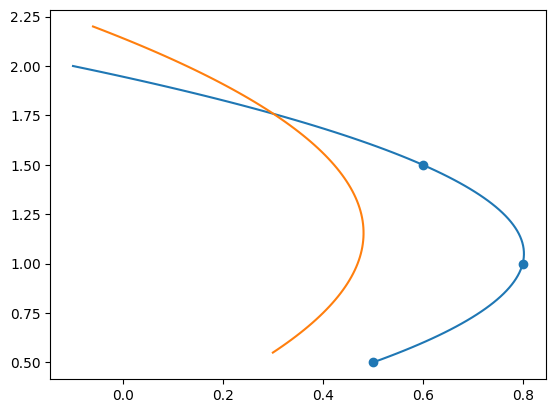

In [5]:
t = np.linspace(start=0.0, stop=len(x1), num=100)
plt.plot(x1_spline(t)*1.0, x2_spline(t))
plt.plot(x1_spline(t)*0.6, x2_spline(t)*1.1)
plt.scatter(x1, x2);

Вище зображена траєкторія цікавого обʼєкту (синім) і траєкторія обʼєкту який є шумним і нас не цікавить.

In [ ]:
from lib.my_kalman import update, predict

In [7]:
class Object:
    __NEXT_ID = 0
    
    def __init__(self, x1_spline, x2_spline, detection_noise=0.1):
        self.id = self.generate_id()
        self.x1_spl = x1_spline
        self.x2_spl = x2_spline
        self.detection_noise = detection_noise
    
    @classmethod
    def generate_id(cls):
        next_id = cls.__NEXT_ID
        cls.__NEXT_ID += 1
        return next_id
        
    def generate_obs(self, t):
        z_x1 = self.x1_spl(t) + np.random.randn() * self.detection_noise
        z_x2 = self.x2_spl(t) + np.random.randn() * self.detection_noise
        return np.array([z_x1, z_x2])

    def get_position(self, t):
        z_x1 = self.x1_spl(t)
        z_x2 = self.x2_spl(t)
        return np.array([z_x1, z_x2])

from dataclasses import dataclass

@dataclass
class ConfidenceWindow:
    x_min: float
    x_max: float
    y_min: float
    y_max: float

    def includes(self, pos):
        return self.x_min <= pos[0] <= self.x_max and self.y_min <= pos[1] <= self.y_max

В наступній клітинці надана імплементація допоміжного об'єкта для слідкування. Такий обʼєкт по суті обертає Фільтр Калмана, але має в собі декілька допоміжних конструкцій.

Трекінг відбувається наступним чином. Стан обʼєкта містить позицію і швидкість і описується нормальним розподілом (адже нагадаю, що в імовірнісній постановці інформація кодується саме розподілами)

$$
x_{mean} = [p_x, p_y, v_x, v_y]
$$
$$
x \sim \mathcal{N}(x_{mean}, \textbf{P})
$$

Надалі ми будемо використовувати $x_{mean}$ та $x$ як синоніми.

Припустимо, що зараз момент $t_{now}$, а розподіл стану описує стан в момент $t_{last}$ - момент останнього оновлення. Використаємо фільтр для прогнозування стану в момент $t_{now}$:

$$ x_{now}, P_{now} = \text{predict}(x, P, dt) $$

Тепер ми маємо оцінку положення об'єкта цієї миті. Це потрібно для того, щоб хоч якось співвідноситись із новими спостереженнями ($z_{i}$) в цей момент часу.

Оскільки деякі спостереження можуть бути нерелевантними (шум або від інших обʼєктів), нам потрібна процедура фільтрації (в звичайному сенсі відбору) правильних спостережень. Існує маса різних способів, але ми скористаємося так званим Гейтінгом (Gating), тобто побудуємо щось на кшталт довірчого інтервалу для положення об'єкта, і відсіємо всі спостереження, що цьому інтервалу (вікну) не належать. Ширина та висота цього вікна обчислюються як:

$$w_{x} = (P_{11} + dt P_{33}) k$$
$$w_{y} = (P_{22} + dt P_{44}) k$$

тут $k$ позначає "кількість сигм" і є параметром, що потрібно налаштувати. Зверніть увагу, що в формулі використовується дисперсія швидкостей помножених на час. Таким чином, чим довше не було оновлень, ти більшим буде довірче вікно.


Зверніть увагу на параметри і обчислення матриці Q. Ви можете пояснити таке обчислення?

In [11]:
class TrackingHypothesis:
    def __init__(self, pos0, t_last=0.0, q_std=0.5, r_std=0.01):
        self.x = np.array([*pos0, 0.0, 0.0])  # x = [pos_x, pos_y, vel_x, vel_y]
        assert self.x.shape == (4,)
        self.P = np.eye(4) * 1.0
        # last t of update
        self.t_last = t_last
        self.q_std = q_std
        self.R = np.array([
            [r_std**2, 0.0],
            [0.0, r_std**2]
        ])
        self.H = np.array([[1.0, 0.0, 0.0, 0.0],
                           [0.0, 1.0, 0.0, 0.0]])

        self.confidence_num_sigmas = 3.0
        self.min_window_size = 0.1

    @staticmethod
    def get_Q(dt, std):
        Ga = np.array([[dt**2 / 2, 0.0],
                       [0.0, dt**2 / 2],
                       [dt, 0.0],
                       [0.0, dt]])
        Cova = np.array([[std**2, 0.0],
                         [0.0, std**2]])
        return Ga.dot(Cova).dot(Ga.T)
    
    @staticmethod
    def get_F(dt):
        return np.array([
            [1.0, 0.0, dt,  0.0],
            [0.0, 1.0, 0.0, dt ],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ])

    def update(self, t_now, obs):
        # звичайне оновлення для КФ
        dt = t_now - self.t_last
        x_next, P_next = predict(self.x, self.P, self.get_F(dt), Q=self.get_Q(dt, self.q_std))
        z = obs
        self.x, self.P = update(x_next, P_next, z, self.R, self.H)
        self.t_last = t_now

    def get_timediff(self, t_now):
        return t_now - self.t_last
        
    def build_confidence_window(self, t_now=0.0):
        dt = t_now - self.t_last

        # Реалізуйте гейтинг. Прогнозуйте стан на dt вперед і див опис в клітинці згори.
        x_next, P_next = predict(self.x, self.P, self.get_F(dt), Q=self.get_Q(dt, self.q_std))
        std_pos_x = P_next[0, 0]
        std_pos_y = P_next[1, 1]
        std_vel_x = P_next[2, 2]
        std_vel_y = P_next[3, 3]

        window_width = (std_pos_x + dt * std_vel_x) * self.confidence_num_sigmas
        window_height = (std_pos_y + dt * std_vel_y) * self.confidence_num_sigmas

        # Важливий крок для стабільності - розмір вікна нехай не зменшується менше min_window_size
        window_width = max(self.min_window_size, window_width)
        window_height = max(self.min_window_size, window_height)
        
        return ConfidenceWindow(
            x_min=x_next[0] - window_width,
            x_max=x_next[0] + window_width,
            y_min=x_next[1] - window_height,
            y_max=x_next[1] + window_height,
        )

# Перевіряємо

Наш трекер майже готовий. Код використання дуже простий. Статистика записується у візуалізаційних цілях.

In [12]:
obj0 = Object(x1_spline, x2_spline, detection_noise=0.01)
obj_false = Object(lambda t: x1_spline(t)*0.6, lambda t: x2_spline(t)*1.1, detection_noise=0.1)

tracking = TrackingHypothesis(pos0=obj0.get_position(0.0), q_std=0.5, r_std=0.1)
stats = []

t0 = 0
for t in np.linspace(start=0.0, stop=T, num=50):
    observation1 = obj0.generate_obs(t)  # z
    true_position = obj0.get_position(t)  # for comparison. In reality, we can't access it.    
    observation2 = obj_false.generate_obs(t)  # simulated clutter/noise

    # storing stats for the frame
    stats.append(
        dict(
            kf_window=tracking.build_confidence_window(t),
            kf_window_dt=tracking.get_timediff(t),
            kf_pos=tracking.x[:2],
            kf_vel=tracking.x[2:],
            true_pos=true_position,
            observations=[observation1, observation2],
        )
    )

    # Основна логіка. Маємо два спостереження в момент часу - observation1 та observation2.
    window = tracking.build_confidence_window(t)
    if tracking.build_confidence_window(t).includes(observation1):
        tracking.update(t, observation1)
    if tracking.build_confidence_window(t).includes(observation2):
        tracking.update(t, observation2)

    print(tracking.x[:2], true_position)

[0.51503074 0.5020821 ] [0.5 0.5]
[0.52699419 0.51716252] [0.53273636 0.53061224]
[0.54284598 0.54283009] [0.5635985  0.56122449]
[0.57464727 0.57224921] [0.59258642 0.59183673]
[0.615857   0.60691224] [0.61970012 0.62244898]
[0.6371469 0.6362172] [0.64493961 0.65306122]
[0.66214553 0.6703822 ] [0.66830487 0.68367347]
[0.68523844 0.69598184] [0.68979592 0.71428571]
[0.70664203 0.72899743] [0.70941274 0.74489796]
[0.73494971 0.76353631] [0.72715535 0.7755102 ]
[0.75078046 0.79166132] [0.74302374 0.80612245]
[0.76676567 0.82167234] [0.75701791 0.83673469]
[0.77891858 0.85490316] [0.76913786 0.86734694]
[0.80188394 0.89247882] [0.77938359 0.89795918]
[0.81095695 0.92458028] [0.7877551  0.92857143]
[0.8192774  0.95786412] [0.79425239 0.95918367]
[0.83126395 0.98820067] [0.79887547 0.98979592]
[0.83771456 1.02258065] [0.80162432 1.02040816]
[0.84479946 1.04815853] [0.80249896 1.05102041]
[0.84792934 1.07738213] [0.80149938 1.08163265]
[0.8499848  1.10699699] [0.79862557 1.1122449 ]
[0.84745

# Візуалізація

In [13]:
x_min, x_max = -0.5, 1.2
y_min, y_max = -0.1, 2.0

class Draw:
    def __init__(self):
        self.fig, self.ax = plt.subplots(dpi=200)
        self.ax.set_xlim(x_min, x_max)
        self.ax.set_ylim(y_min, y_max)

        self.kf_window_plot, = self.ax.plot([], [], label="kf_window")
        self.kf_pos_plot = self.ax.scatter([], [], label="kf_pos")
        self.kf_vel_plot, = self.ax.plot([], [], label="kf_vel")
    
        self.true_pos_plot = self.ax.scatter([], [], label="true_pos")
        self.obs_plot = self.ax.scatter([], [], label="observations")
    
        self.ax.legend(loc="lower left")
    
    def draw_window(self, win):
        plt.plot([win.x_min, win.x_min, win.x_max, win.x_max, win.x_min],
                 [win.y_min, win.y_max, win.y_max, win.y_min, win.y_min])
    
    def draw_frame(self, i):
        frame_stats = stats[i]
    
        kf_window = frame_stats["kf_window"]
        kf_window_dt = frame_stats["kf_window_dt"]
        kf_pos = frame_stats["kf_pos"]
        kf_vel = frame_stats["kf_vel"]
        true_pos = frame_stats["true_pos"]
        observations = frame_stats["observations"]
    
        win = kf_window
        self.kf_window_plot.set_data(
            [win.x_min, win.x_min, win.x_max, win.x_max, win.x_min],
            [win.y_min, win.y_max, win.y_max, win.y_min, win.y_min])
    
        self.kf_pos_plot.set_offsets([kf_pos])
        self.kf_vel_plot.set_data(
            [kf_pos[0], kf_pos[0] + kf_window_dt * kf_vel[0]],
            [kf_pos[1], kf_pos[1] + kf_window_dt * kf_vel[1]])
    
        self.true_pos_plot.set_offsets([true_pos])
    
        self.obs_plot.set_offsets(observations)

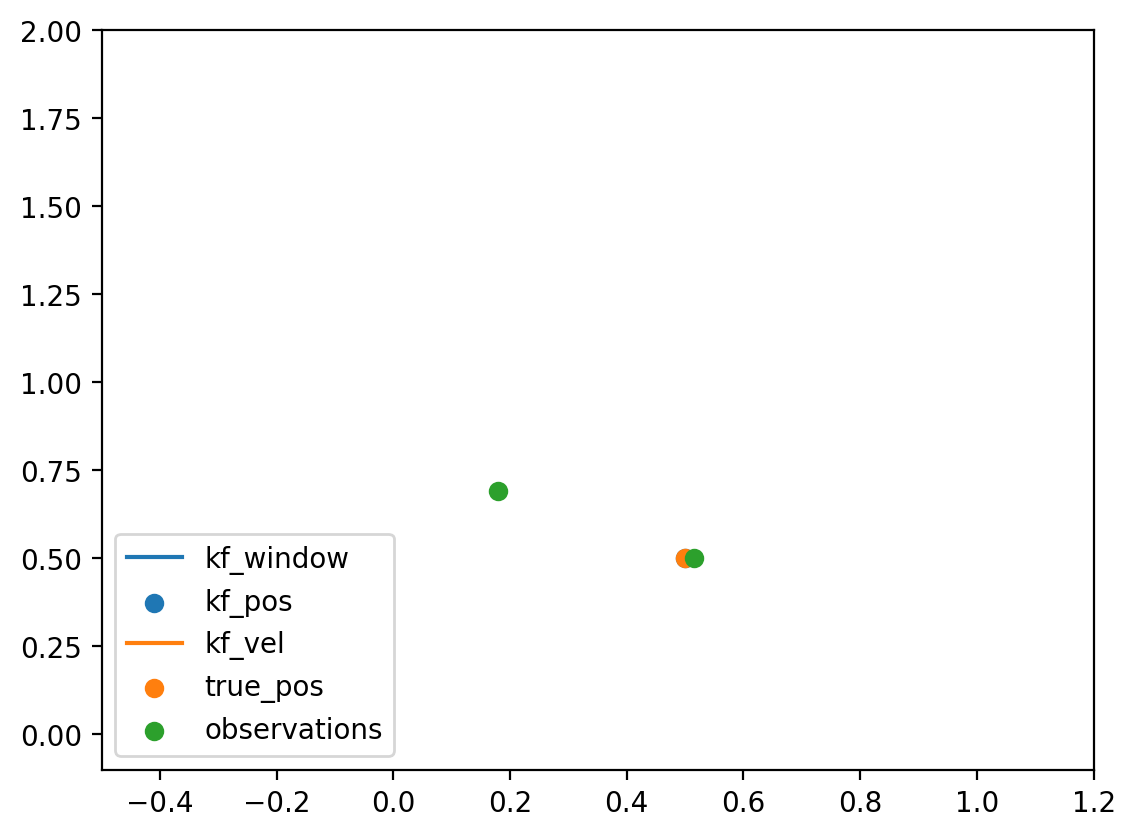

In [14]:
import matplotlib.animation

draw = Draw()
ani = matplotlib.animation.FuncAnimation(draw.fig, draw.draw_frame, frames=len(stats))
from IPython.display import HTML
HTML(ani.to_jshtml())